In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import PIL
import glob
from custom_gen import DataGenerator
from vae import VAE, Sampling

In [24]:
params = {'dim': (64,64,1),
          'batch_size': 128,
          'n_classes': 1,
          'n_channels': 1,
          'shuffle': True}
digits = glob.glob('by_class/3*/*.png')
input_data = DataGenerator(digits,[0]*len(digits),**params)

In [25]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 16384)        0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [26]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             49152     
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 1)         289       
Total params: 77,153
Trainable params: 77,153
Non-trainable params: 0
_______________________________________________________

In [29]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(),run_eagerly=True)
vae.fit(input_data, epochs=1)

5837/5837 [==============================] - 3481s 596ms/step - loss: 534.1815 - reconstruction_loss: 601.2788 - kl_loss: 967.0588


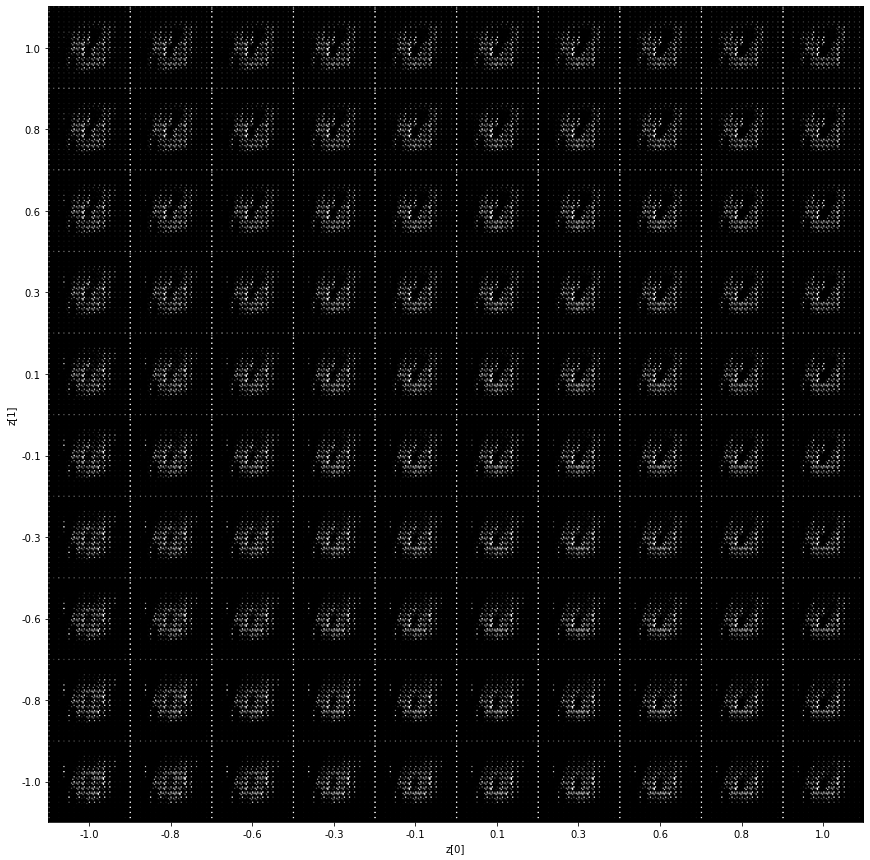

In [30]:
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.savefig('manifold.png')
    plt.show()


plot_latent_space(vae)

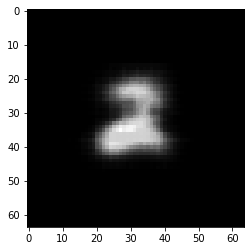

In [18]:
plt.imshow(vae.decoder.predict(np.array(([[0.,1.]]))).reshape(64,64),cmap='binary')